In [23]:
import os
import pandas as pd
import elapid as ela
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
from sklearn.inspection import partial_dependence, permutation_importance

mpl.style.use("ggplot")

### Load kikuyugrass observations, background points, and climate data

In [37]:
data = pd.read_csv("./location_climate_data.csv")

In [38]:
data["class"] = data["type"].apply(lambda x: 1 if x == "kikuyugrass" else 0)
data = data.drop(columns=["Unnamed: 0"])

In [39]:
data.head()

,lat,long,uuid,type,ai,bio10,bio11,bio12,bio13,bio14,...,ngd5,npp,pet,rsds,scd,sfcWind,swb,swe,vpd,class
0,34.041287,-118.532091,cf6f9a84-0996-4ded-b2e0-a7bd12d67217,kikuyugrass,0.331897,2950,2862,3857,966,6,...,365,6562,12501,18098,0,364,-980,65535,4835,1
1,32.658961,-117.060481,39f544ee-5509-49ea-a296-19c825217ee1,kikuyugrass,0.286715,2938,2869,2806,571,14,...,365,4931,10485,17475,0,155,-858,65535,2625,1
2,35.322144,-120.823204,28751c0a-3cd3-4f64-9058-75e564f328f8,kikuyugrass,0.550209,2912,2851,5192,1067,7,...,365,8482,12271,20092,0,599,-756,65535,2197,1
3,32.737291,-117.126908,192ed8dc-5066-42cb-b58f-8cf69f070b2a,kikuyugrass,0.278504,2939,2866,2782,568,11,...,365,4893,10851,17513,0,186,-891,65535,2424,1
4,32.781962,-117.075417,0064ea02-de18-4098-996b-0814a9935c3b,kikuyugrass,0.268646,2943,2865,2932,602,13,...,365,5133,11567,18090,0,171,-889,65535,3064,1


In [40]:
data.columns

Index(['lat', 'long', 'uuid', 'type', 'ai', 'bio10', 'bio11', 'bio12', 'bio13',
       'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'bio1', 'bio2',
       'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9', 'clt', 'cmi',
       'fcf', 'fgd', 'gdd0', 'gdd10', 'gdd5', 'gddlgd0', 'gddlgd10', 'gddlgd5',
       'gdgfgd0', 'gdgfgd10', 'gdgfgd5', 'gsl', 'gsp', 'gst', 'hurs', 'kg0',
       'kg1', 'kg2', 'kg3', 'kg4', 'kg5', 'lgd', 'ngd0', 'ngd10', 'ngd5',
       'npp', 'pet', 'rsds', 'scd', 'sfcWind', 'swb', 'swe', 'vpd', 'class'],
      dtype='object')

In [41]:
data.describe()

,lat,long,ai,bio10,bio11,bio12,bio13,bio14,bio15,bio16,...,ngd5,npp,pet,rsds,scd,sfcWind,swb,swe,vpd,class
count,10233.000000,10233.000000,10233.000000,10233.000000,10233.000000,10233.000000,10233.000000,10233.000000,10233.000000,10233.000000,...,10233.000000,10233.000000,10233.000000,10233.000000,10233.000000,10233.000000,10233.000000,10233.000000,10233.000000,10233.000000
mean,37.189370,-119.623092,0.609679,2961.984267,2798.189290,6499.639988,1251.396853,35.219291,769.054236,3393.386983,...,319.746311,8024.472980,15364.024724,20973.786671,32.561614,730.936969,-1127.300303,53858.796541,13415.690511,0.033421
std,2.598593,2.512241,0.602608,54.830785,53.724708,5527.312436,1098.102422,44.418251,144.077336,2914.027817,...,70.946505,4551.483082,1810.877849,1595.093480,75.148496,415.493763,2582.856532,24483.897561,6645.291975,0.179743
min,32.545694,-124.354306,0.036301,2786.000000,2596.000000,678.000000,109.000000,1.000000,286.000000,298.000000,...,61.000000,1274.000000,6736.000000,13753.000000,0.000000,41.000000,-32768.000000,35.000000,646.000000,0.000000
25%,34.987361,-121.662639,0.168837,2923.000000,2762.000000,2300.000000,414.000000,7.000000,654.000000,1133.000000,...,268.000000,4106.000000,14477.000000,19804.000000,0.000000,428.000000,-1224.000000,65535.000000,8876.000000,0.000000
50%,36.912361,-120.037639,0.384860,2956.000000,2817.000000,4580.000000,901.000000,17.000000,813.000000,2468.000000,...,365.000000,7470.000000,15617.000000,20963.000000,0.000000,667.000000,-903.000000,65535.000000,12361.000000,0.000000
75%,39.429027,-117.529306,0.869589,3000.000000,2833.000000,9229.000000,1748.000000,48.000000,875.000000,4904.000000,...,365.000000,11311.000000,16418.000000,22375.000000,0.000000,943.000000,-589.000000,65535.000000,17358.000000,0.000000
max,42.004027,-114.245972,4.039871,3116.000000,2896.000000,31681.000000,6705.000000,388.000000,1041.000000,16985.000000,...,365.000000,19824.000000,23747.000000,24634.000000,365.000000,3750.000000,-136.000000,65535.000000,40226.000000,1.000000


### Setup model

In [42]:
# initialize and print the model defaults
model = ela.MaxentModel()

model.get_params()

{'beta_categorical': 1.0,
 'beta_hinge': 1.0,
 'beta_lqp': 1.0,
 'beta_multiplier': 1.5,
 'beta_threshold': 1.0,
 'clamp': True,
 'class_weights': 100,
 'convergence_tolerance': 2e-06,
 'feature_types': ['linear', 'hinge', 'product'],
 'n_cpus': 8,
 'n_hinge_features': 10,
 'n_lambdas': 100,
 'n_threshold_features': 10,
 'scorer': 'roc_auc',
 'tau': 0.5,
 'transform': 'cloglog',
 'use_lambdas': 'best',
 'use_sklearn': True}

In [43]:
# set up the x/y data for model fitting
x = data[[f"bio{i}" for i in range(1, 20)]].copy()
# x2 = data.drop(columns=['class', 'type', "uuid", "ai", "lat", "long"])

y = data["class"]

### Fit and predict

In [44]:
model.fit(x, y)

ypred = model.predict(x)
auc = metrics.roc_auc_score(y, ypred)
print(f"Training AUC score (bio1 to bio19): {auc:0.3f}")

Training AUC score (bio1 to bio19): 0.983


### Convert units

In [46]:
x.head()

,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
0,2903,98,5.02,3365,3011,2815,196,2867,2942,2950,2862,3857,966,6,998,2360,35,66,2352
1,2900,71,4.69,2665,2982,2831,151,2872,2928,2938,2869,2806,571,14,887,1555,53,79,1478
2,2882,76,5.15,2404,2962,2814,148,2851,2907,2912,2851,5192,1067,7,946,3029,39,64,3029
3,2900,74,4.59,2816,2986,2825,161,2869,2930,2939,2866,2782,568,11,893,1554,45,71,1483
4,2901,87,4.87,2978,2997,2818,179,2869,2933,2943,2865,2932,602,13,893,1646,49,75,1565


In [54]:
def celsius_to_fahrenheit(c):
    return (c * 9 / 5) + 32


def celsius_range_to_fahrenheit(c_range):
    return c_range * (9 / 5)


def mm_to_inches(mm):
    return mm / 25.4

### Partial dependence

In [55]:
labels = [f"bio{i}" for i in range(1, 20)]

In [57]:
def partial_dependence_scores(estimator, x, percentiles=(0.025, 0.975), n_bins=100):
    """Compute partial dependence scores for each feature"""
    ncols = x.shape[1]
    mean = np.zeros((ncols, n_bins))
    stdv = np.zeros_like(mean)
    bins = np.zeros_like(mean)

    for idx in range(ncols):
        pd = partial_dependence(
            estimator,
            x,
            [idx],
            percentiles=percentiles,
            grid_resolution=n_bins,
            kind="individual",
        )
        mean[idx] = pd["individual"][0].mean(axis=0)
        stdv[idx] = pd["individual"][0].std(axis=0)
        bins[idx] = pd["grid_values"][0]

    return bins, mean, stdv


def partial_dependence_plot(
    estimator, x, percentiles=(0.025, 0.975), n_bins=50, labels=None, **kwargs
):
    """Plot the response of an estimator across the range of feature values"""
    bins, mean, stdv = partial_dependence_scores(
        estimator, x, percentiles=percentiles, n_bins=n_bins
    )

    ncols = x.shape[1]
    figx = int(np.ceil(np.sqrt(ncols)))
    figy = int(np.ceil(ncols / figx))
    fig, ax = plt.subplots(figx, figy, **kwargs)
    ax = ax.flatten()

    # convert units
    for idx in range(ncols):
        if labels[idx] in ["bio1", "bio5", "bio6", "bio8", "bio9", "bio10", "bio11"]:
            bins[idx] = celsius_to_fahrenheit(bins[idx] * 0.1 - 273.15)
        elif labels[idx] in ["bio2", "bio7"]:
            bins[idx] = celsius_range_to_fahrenheit(bins[idx] * 0.1)
        elif labels[idx] in ["bio3", "bio15"]:
            bins[idx] = bins[idx] * 0.1
        elif labels[idx] == "bio4":
            bins[idx] = celsius_range_to_fahrenheit(bins[idx] / 100 * 0.01)
        elif labels[idx] in [
            "bio12",
            "bio13",
            "bio14",
            "bio16",
            "bio17",
            "bio18",
            "bio19",
        ]:
            bins[idx] = mm_to_inches(bins[idx] * 0.1)

        ax[idx].fill_between(
            bins[idx], mean[idx] - stdv[idx], mean[idx] + stdv[idx], alpha=0.25
        )
        ax[idx].plot(bins[idx], mean[idx])
        ax[idx].set_title(labels[idx])

    # turn off empty plots
    for axi in ax:
        if not axi.lines:
            axi.set_visible(False)

    fig.tight_layout()

    return fig, ax

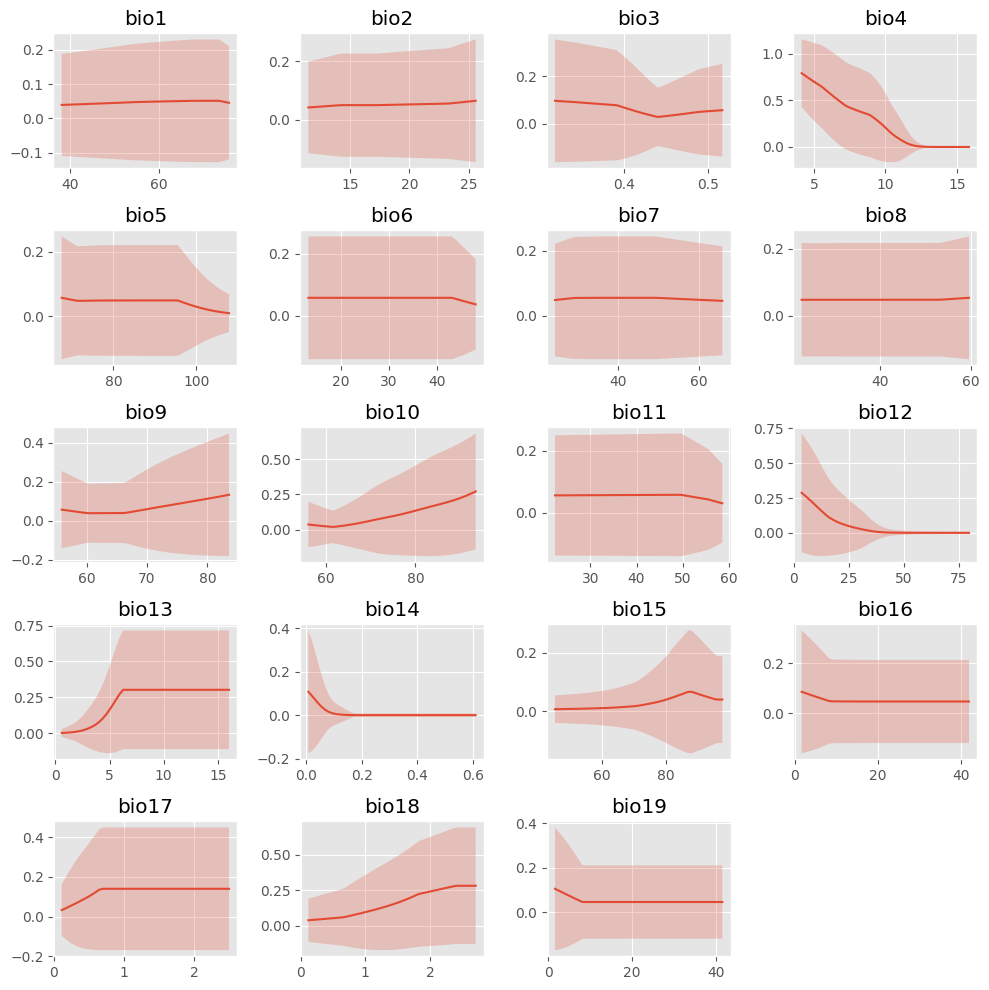

In [58]:
fig, ax = partial_dependence_plot(model, x, labels=labels, figsize=(10, 10), dpi=100)
plt.show()

### Permutation importance

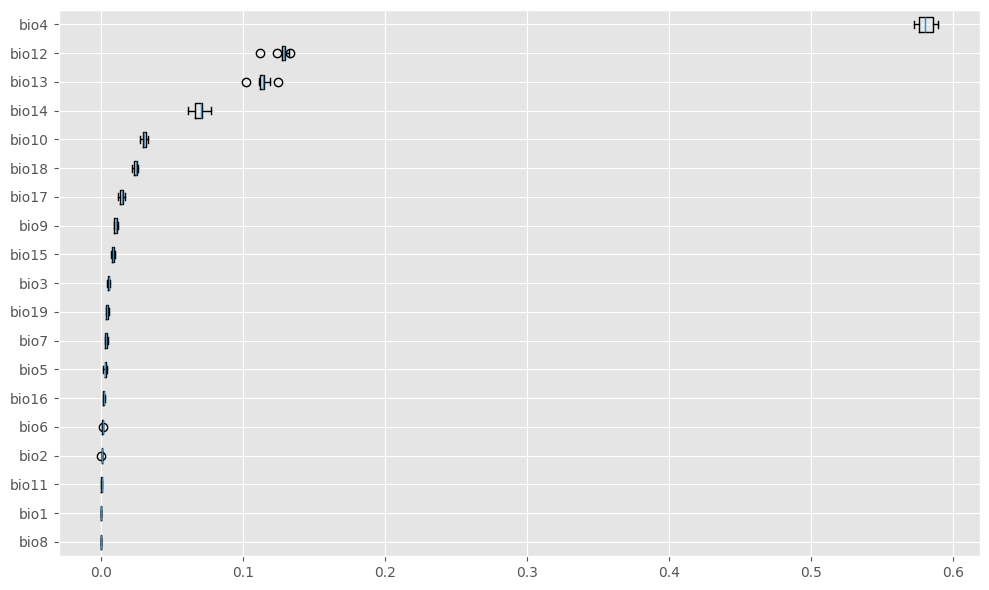

In [59]:
result = permutation_importance(model, x, y, n_repeats=10, random_state=42)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=np.array(labels)[sorted_idx]
)
fig.tight_layout()
plt.show()

# bio4 temperature seasonality, standard deviation of the monthly temps
# bio12 annual precipitation
# bio13 precipitation of the wettest month
# bio14 precipitation of the driest month

### Generate predictions on raster

In [60]:
url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
us_states = gpd.read_file(url)
california = us_states[us_states["NAME"] == "California"]

In [61]:
raster_names = [f"CHELSA_bio{i}_1981-2010_V.2.1.tif" for i in range(1, 20)]
global_rasters = [f"./climate_data/{raster}" for raster in raster_names]

In [62]:
os.makedirs("./climate_data_clipped", exist_ok=True)

clipped_rasters = []
for raster in global_rasters:
    with rasterio.open(raster) as src:
        california = california.to_crs(src.crs)
        geoms = california.geometry.values
        out_image, out_transform = mask(src, geoms, crop=True, nodata=-9999)
        out_meta = src.meta.copy()
        out_meta.update(
            {
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
                "dtype": "int16",
                "nodata": -9999,
            }
        )
        clipped_raster = raster.replace("climate_data", "climate_data_clipped")
        with rasterio.open(clipped_raster, "w", **out_meta) as dest:
            dest.write(out_image)
        clipped_rasters.append(clipped_raster)

In [63]:
output_raster = "kikuyugrass_predictions.tif"
ela.apply_model_to_rasters(model, clipped_rasters, output_raster, quiet=True)

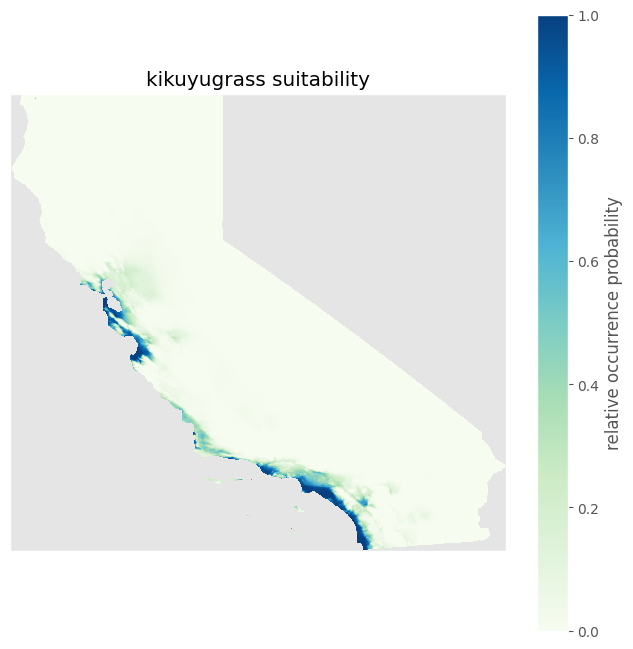

In [64]:
with rasterio.open(output_raster, "r") as src:
    pred = src.read(1, masked=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
plot = ax.imshow(pred, vmin=0, vmax=1, cmap="GnBu")
ax.set_title("kikuyugrass suitability")
ax.set_xticks([])
ax.set_yticks([])
cbar = plt.colorbar(plot, ax=ax, label="relative occurrence probability")
plt.show()